# Customer Churn Prediction
## Goal: Predict customer churn using Machine Learning.

**Workflow:**
1. Data Exploration (EDA)
2. Preprocessing & Balancing (SMOTE)
3. Model Selection (Compare 7+ models)
4. Hyperparameter Tuning (Top 3 models)
5. Final Evaluation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

%matplotlib inline


In [2]:
# Load Dataset
df = pd.read_csv('Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


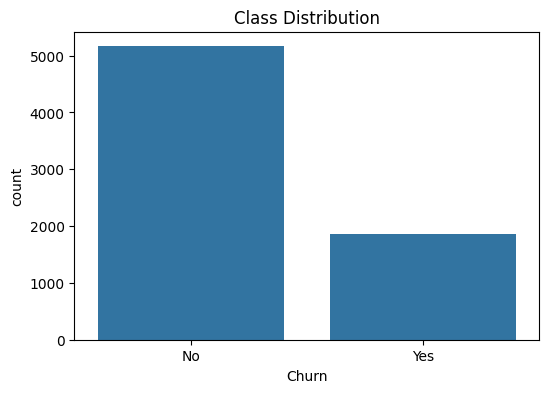

In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Class Distribution')
plt.show()


In [4]:
# Encoding
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if col != 'Churn':
        df[col] = le.fit_transform(df[col])
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Split & Scale
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f'Train size: {X_train.shape}, Resampled size: {X_train_resampled.shape}')


Train size: (5625, 19), Resampled size: (8260, 19)


In [5]:
# Define Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVC': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

results = []

print('--- Training Candidate Models ---')
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({'Model': name, 'Accuracy': acc, 'F1': f1, 'AUC': auc})
    print(f'{name} -> Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}')

results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
results_df


--- Training Candidate Models ---
Logistic Regression -> Acc: 0.7363, F1: 0.6147, AUC: 0.8335
SVC -> Acc: 0.7470, F1: 0.5955, AUC: 0.8068
KNN -> Acc: 0.7008, F1: 0.5682, AUC: 0.7682
Random Forest -> Acc: 0.7726, F1: 0.5789, AUC: 0.8113


c:\Users\burug\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:29:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost -> Acc: 0.7640, F1: 0.5688, AUC: 0.8102
Gradient Boosting -> Acc: 0.7733, F1: 0.6216, AUC: 0.8342
AdaBoost -> Acc: 0.7356, F1: 0.6051, AUC: 0.8309


,Model,Accuracy,F1,AUC
5,Gradient Boosting,0.773276,0.621590,0.834174
0,Logistic Regression,0.736318,0.614746,0.833452
6,AdaBoost,0.735608,0.605096,0.830869
1,SVC,0.746979,0.595455,0.806792
3,Random Forest,0.772566,0.578947,0.811270
4,XGBoost,0.764037,0.568831,0.810186
2,KNN,0.700782,0.568205,0.768203


In [6]:
# Select Top 3 Models based on F1 Score
top_3_names = results_df['Model'].head(3).tolist()
print('Top 3 Models selected for tuning:', top_3_names)


Top 3 Models selected for tuning: ['Gradient Boosting', 'Logistic Regression', 'AdaBoost']


In [7]:
# Hyperparameter Grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'AdaBoost': {
         'n_estimators': [50, 100, 200],
         'learning_rate': [0.01, 0.1, 1.0]
    }
}

best_models = {}

for name in top_3_names:
    if name in param_grids:
        print(f'\n--- Tuning {name} ---')
        base_model = models[name]
        grid = GridSearchCV(base_model, param_grids[name], cv=3, scoring='f1', n_jobs=-1, verbose=1)
        grid.fit(X_train_resampled, y_train_resampled)
        best_models[name] = grid.best_estimator_
        print(f'Best Params for {name}: {grid.best_params_}')
        print(f'Best CV F1: {grid.best_score_:.4f}')
    else:
        print(f'No params defined for {name}, skipping tuning.')



--- Tuning Gradient Boosting ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best CV F1: 0.8128

--- Tuning Logistic Regression ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params for Logistic Regression: {'C': 1, 'penalty': 'l2'}
Best CV F1: 0.7921

--- Tuning AdaBoost ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 100}
Best CV F1: 0.8078



=== Final Evaluation: Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1033
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407



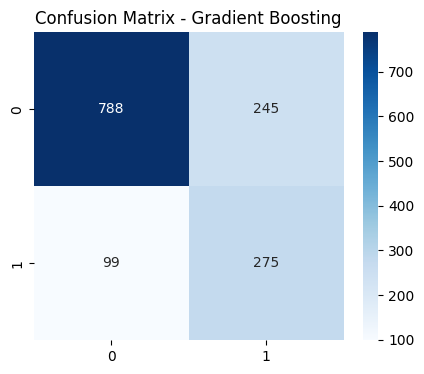


=== Final Evaluation: Logistic Regression ===
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407



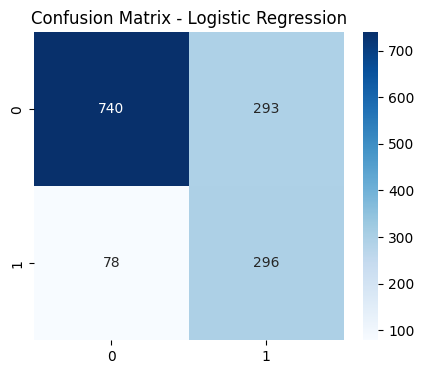


=== Final Evaluation: AdaBoost ===
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.77      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407



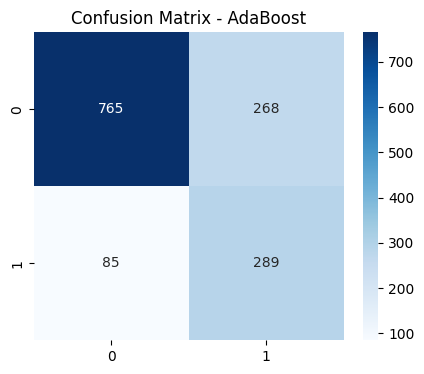

In [8]:
# Evaluate Tuned Models
for name, model in best_models.items():
    print(f'\n=== Final Evaluation: {name} ===')
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
